Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (session_length и window_size) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

#### План 4 недели:

- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация конкретного пользователя и кривые обучения

В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":

- Линейная классификация
- Сравнение алгоритмов и выбор гиперпараметров
- Кросс-валидация. Sklearn.cross_validation
- Линейные модели. Sklearn.linear_model. Классификация
и многие другие

# Задание
Заполните код в этой тетрадке
Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment.
Если вы проходите курс ODS, выберите ответы в веб-форме.

In [1]:
# pip install watermark
%load_ext watermark

In [ ]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

In [59]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [60]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

Загрузим сериализованные ранее объекты X_sparse_10users и y_10users, соответствующие обучающей выборке для 10 пользователей

In [61]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов

In [62]:
X_sparse_10users.shape

(14061, 4913)

Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.

In [63]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, random_state=17, 
                                                      stratify=y_10users)

Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.

In [64]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).

In [65]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

1. Обучите KNeighborsClassifier со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только n_jobs=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект StratifiedKFold skf) по выборке (X_train, y_train) и отдельно на выборке (X_valid, y_valid).

In [66]:
from sklearn.neighbors import KNeighborsClassifier

In [67]:
knn = KNeighborsClassifier(n_neighbors=100)
knn_cross_val_score = cross_val_score(knn, X_train, y_train, 
                                      cv=skf, scoring='accuracy').mean()
print('kNN cross_val_score: {}'.format(knn_cross_val_score))
knn.fit(X_train, y_train)
knn_valid_score = accuracy_score(y_valid, knn.predict(X_valid))
print('kNN valid accuracy score: {}'.format(knn_valid_score))

kNN cross_val_score: 0.5593373897012363
kNN valid accuracy score: 0.584024650391088


Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.

In [68]:
def write_answer_to_file(answer, file):
    with open(file, 'w') as f:
        f.write(' '.join(map(str, answer)))

answer4_1 = [round(x, 3) for x in [knn_cross_val_score, knn_valid_score]]
write_answer_to_file(answer4_1, 'answers/answer4_1.txt')

2. Обучите случайный лес (RandomForestClassifier) из 100 деревьев (для воспроизводимости random_state=17). Посмотрите на OOB-оценку (для этого надо сразу установить oob_score=True) и на долю правильных ответов на выборке (X_valid, y_valid). Для распараллеливания задайте n_jobs=-1.

In [69]:
from sklearn.ensemble import RandomForestClassifier

In [70]:
forest = RandomForestClassifier(n_estimators=100,oob_score=True, random_state=17)
forest.fit(X_train, y_train)
print('RandomForestClassifier OOB-score: {}'.format(forest.oob_score_))
forest_valid_score = accuracy_score(y_valid, forest.predict(X_valid))
print('RandomForestClassifier valid accuracy score: {}'.format(forest_valid_score))

RandomForestClassifier OOB-score: 0.7172322698638488
RandomForestClassifier valid accuracy score: 0.7312159279450107


Посчитайте доли правильных ответов для RandomForestClassifier при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.

In [71]:
answer4_2 = [round(x, 3) for x in [forest.oob_score_, forest_valid_score]]
write_answer_to_file(answer4_2, 'answers/answer4_2.txt')
print(' '.join(map(str,answer4_2)))

0.717 0.731


3. Обучите логистическую регрессию (LogisticRegression) с параметром C по умолчанию и random_state=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект skf, созданный ранее) и на выборке (X_valid, y_valid). Для распараллеливания задайте n_jobs=-1.

In [77]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [78]:
logit = LogisticRegression(random_state=17)
logit_cross_val_score = cross_val_score(logit, X_train, y_train, 
                                        cv=skf, scoring='accuracy').mean()
print('LogisticRegression cross_val_score: {}'.format(logit_cross_val_score))
logit.fit(X_train, y_train)
logit_valid_score = accuracy_score(y_valid, logit.predict(X_valid))
print('LogisticRegression valid accuracy score: {}'.format(logit_valid_score))

LogisticRegression cross_val_score: 0.7606189739891912
LogisticRegression valid accuracy score: 0.7767243422611994


Почитайте документацию к LogisticRegressionCV. Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации C (быстрее, чем с GridSearchCV).

С помощью LogisticRegressionCV подберите параметр C для LogisticRegression сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте logspace из NumPy. Укажите у LogisticRegressionCV параметры multi_class='multinomial' и random_state=17. Для кросс-валидации используйте объект skf, созданный ранее. Для распараллеливания задайте n_jobs=-1.

Нарисуйте кривые валидации по параметру C.

In [88]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, 
                                            multi_class='multinomial', 
                                            cv=skf, random_state=17, n_jobs=-1)  
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 15.6 s


LogisticRegressionCV(Cs=array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='multinomial', n_jobs=-1, random_state=17)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров C.

In [89]:
np.array(list(logit_grid_searcher1.scores_.values())).shape

(10, 3, 10)

In [90]:
logit_mean_cv_scores1 = np.array(list(logit_grid_searcher1.scores_.values())).mean(axis = (0, 1))
logit_mean_cv_scores1

array([0.31954964, 0.47307397, 0.55202236, 0.64875035, 0.71438846,
       0.75177962, 0.76072066, 0.75858707, 0.7499505 , 0.73999338])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение C.

In [91]:
best_accuracy_score1 = max(logit_mean_cv_scores1)
print('The best accuracy score: {}'.format(best_accuracy_score1))
best_c_value1 = logit_grid_searcher1.Cs_[np.argmax(logit_mean_cv_scores1)]
print('The best C value: {}'.format(best_c_value1))

The best accuracy score: 0.7607206619536478
The best C value: 1.0


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от C

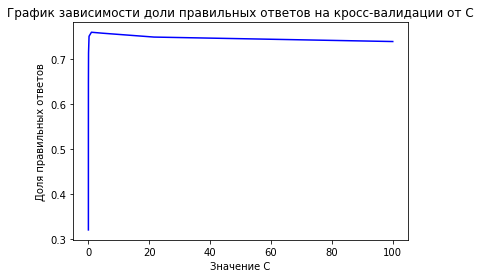

In [92]:
plt.plot(logit_c_values1, logit_mean_cv_scores1, color='blue')
plt.title('График зависимости доли правильных ответов на кросс-валидации от С')
plt.xlabel('Значение С')
plt.ylabel('Доля правильных ответов')
plt.show()

#### Теперь то же самое, только значения параметра C перебирайте в диапазоне np.linspace(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.

In [99]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs = logit_c_values2, cv = skf, 
                                            multi_class = 'multinomial', random_state = 17, n_jobs = -1)
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 37.4 s


LogisticRegressionCV(Cs=array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ]),
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='multinomial', n_jobs=-1, random_state=17)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров C.

In [100]:
logit_mean_cv_scores2 = np.array(list(logit_grid_searcher2.scores_.values())).mean(axis = (0, 1))
logit_mean_cv_scores2

array([0.73481117, 0.75929815, 0.76122867, 0.76092376, 0.76133023,
       0.76143192, 0.75990775, 0.75939974, 0.75970453, 0.75929821,
       0.75919661, 0.75858698, 0.75777419, 0.75736787, 0.75696143,
       0.75604698, 0.75543744, 0.75513266, 0.75411661, 0.75330373])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение C.

In [101]:
best_accuracy_score2 = max(logit_mean_cv_scores2)
print('The best accuracy score: {}'.format(best_accuracy_score2))
best_c_value2 = logit_grid_searcher2.Cs_[np.argmax(logit_mean_cv_scores2)]
print('The best C value: {}'.format(best_c_value2))

The best accuracy score: 0.761431920171076
The best C value: 1.9157894736842107


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от C.

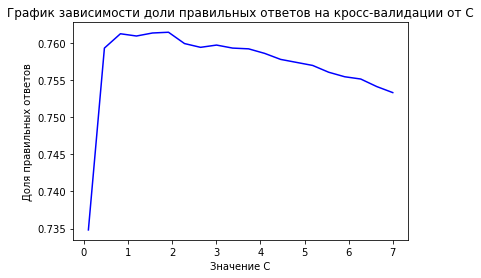

In [102]:
plt.plot(logit_c_values2, logit_mean_cv_scores2, color='blue')
plt.title('График зависимости доли правильных ответов на кросс-валидации от С')
plt.xlabel('Значение С')
plt.ylabel('Доля правильных ответов')
plt.show()

Выведите долю правильных ответов на выборке (X_valid, y_valid) для логистической регрессии с лучшим найденным значением C.

In [103]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))
print(logit_cv_acc)

0.7802796871296516


Посчитайте доли правильных ответов для logit_grid_searcher2 на кросс-валидации для лучшего значения параметра C и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.

In [104]:
logit_cv_cvs = cross_val_score(logit_grid_searcher2, X_train, y_train, 
                               cv=skf, scoring='accuracy').mean()
print('LogisticRegression with best C cross_val_score: {}'.format(logit_cv_cvs.mean()))
print('LogisticRegression with best C valid accuracy score: {}'.format(logit_cv_acc))

LogisticRegression with best C cross_val_score: 0.7613301702584231
LogisticRegression with best C valid accuracy score: 0.7802796871296516


In [105]:
answer4_3 = [round(x, 3) for x in [logit_cv_cvs, logit_cv_acc]]
write_answer_to_file(answer4_3, 'answers/answer4_3.txt')

4. Обучите линейный SVM (LinearSVC) с параметром C=1 и random_state=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект skf, созданный ранее) и на выборке (X_valid, y_valid).

In [106]:
from sklearn.svm import LinearSVC

In [107]:
svm = LinearSVC(C=1, random_state=17)
svm_cross_val_score = cross_val_score(svm, X_train, y_train, 
                                      cv=skf, scoring='accuracy').mean()
print('SVM cross_val_score: {}'.format(svm_cross_val_score))

SVM cross_val_score: 0.7509671352428245


С помощью GridSearchCV подберите параметр C для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте linspace из NumPy. Нарисуйте кривые валидации.

In [108]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}
svm_grid_searcher1 = GridSearchCV(svm, svm_params1, scoring='accuracy', 
                                  return_train_score=True)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 1min 18s


GridSearchCV(estimator=LinearSVC(C=1, random_state=17),
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])},
             return_train_score=True, scoring='accuracy')

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение C.

In [109]:
print('The best cross-validation accuracy score: {}'.format(svm_grid_searcher1.best_score_))
print('The best C value: {}'.format(svm_grid_searcher1.best_params_))

The best cross-validation accuracy score: 0.6952843773612952
The best C value: {'C': 4444.4445000000005}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от C.

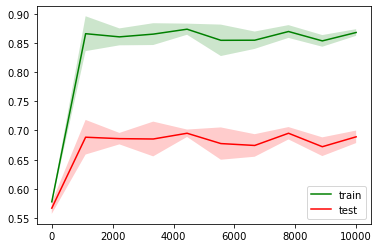

In [110]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

#### Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений C). Здесь намного осмысленней подбирать C в районе 1, к тому же, так модель быстрее обучается, чем при больших C.

С помощью GridSearchCV подберите параметр C для SVM в диапазоне (1e-3, 1), 30 значений, используйте linspace из NumPy. Нарисуйте кривые валидации.

In [111]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}
svm_grid_searcher2 = GridSearchCV(svm, svm_params2, scoring='accuracy', 
                                  return_train_score=True)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 2min 18s


GridSearchCV(estimator=LinearSVC(C=1, random_state=17),
             param_grid={'C': array([0.001     , 0.03544828, 0.06989655, 0.10434483, 0.1387931 ,
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])},
             return_train_score=True, scoring='accuracy')

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение C

In [112]:
print('The best cross-validation accuracy score: {}'.format(svm_grid_searcher2.best_score_))
print('The best C value: {}'.format(svm_grid_searcher2.best_params_))

The best cross-validation accuracy score: 0.7701686093803548
The best C value: {'C': 0.10434482758620689}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

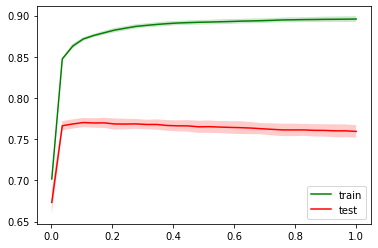

In [113]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке (X_valid, y_valid) для LinearSVC с лучшим найденным значением C.

In [114]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.best_estimator_.predict(X_valid))
print(svm_cv_acc)

0.7807537331121118


Посчитайте доли правильных ответов для svm_grid_searcher2 на кросс-валидации для лучшего значения параметра C и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.

In [115]:
svm_cv_cvs = cross_val_score(svm_grid_searcher2.best_estimator_, X_train, y_train, 
                             cv=skf, scoring='accuracy').mean()
print('SVM with the best C cross_val_score: {}'.format(svm_cv_cvs))
print('SVM with the best C valid accuracy score: {}'.format(svm_cv_acc))

SVM with the best C cross_val_score: 0.7670206386611259
SVM with the best C valid accuracy score: 0.7807537331121118


In [116]:
answer4_4 = [round(x, 3) for x in [svm_cv_cvs, svm_cv_acc]]
write_answer_to_file(answer4_4, 'answers/answer4_4.txt')

### Часть 2. Выбор параметров – длины сессии и ширины окна

##### Возьмем LinearSVC, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров session_length и window_size). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации C.

Определите функцию model_assessment, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение выборки с train_test_split должно быть стратифицированным. Не теряйте нигде random_state.

In [117]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    # read pickle files
    with open(path_to_X_pickle, 'rb') as X_f:
        X_sparse = pickle.load(X_f)
    with open(path_to_y_pickle, 'rb') as y_f:
        y = pickle.load(y_f)
    
    #split
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, stratify=y, 
                                                          random_state=17, test_size=test_size)
    
    #make scores
    estimator_cvs = cross_val_score(estimator, X_train, y_train, 
                                    cv=cv, scoring='accuracy').mean()
    estimator.fit(X_train, y_train)
    estimator_valid_acc = accuracy_score(y_valid, estimator.predict(X_valid))
    
    return(estimator_cvs, estimator_valid_acc)

Убедитесь, что функция работает.

In [118]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'), 
                 os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, 
                 random_state=17, test_size=0.3)

(0.7670206386611259, 0.7807537331121118)

Примените функцию model_assessment для лучшего алгоритма из предыдущей части (а именно, svm_grid_searcher2.best_estimator_) и 9 выборок вида с разными сочетаниями параметров session_length и window_size для 10 пользователей. Выведите в цикле параметры session_length и window_size, а также результат вывода функции model_assessment. Удобно сделать так, чтоб model_assessment возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10.

In [124]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl

ЌҐ г¤ Ґвбп ­ ©вЁ гЄ § ­­л© д ©«.
ЋиЁЎЄ  ў бЁ­в ЄбЁбҐ Є®¬ ­¤л.
ЋиЁЎЄ  ў бЁ­в ЄбЁбҐ Є®¬ ­¤л.
ЋиЁЎЄ  ў бЁ­в ЄбЁбҐ Є®¬ ­¤л.


In [125]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_10users_s{}_w{}.pkl'.format(session_length, 
                                                                                         window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_10users_s{}_w{}.pkl'.format(session_length, 
                                                                                  window_size))
        print('session_length = {}\nwindow_size = {}'.format(session_length, 
                                                             window_size))
        res = [round(x, 3) for x in model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, cv=skf)]
        print('cross_val_score = {}, valid accuracy score = {}\n'.format(res[0], res[1]))

session_length = 15
window_size = 10
cross_val_score = 0.824, valid accuracy score = 0.84

session_length = 10
window_size = 10
cross_val_score = 0.767, valid accuracy score = 0.781

session_length = 15
window_size = 7
cross_val_score = 0.85, valid accuracy score = 0.854

session_length = 10
window_size = 7
cross_val_score = 0.798, valid accuracy score = 0.807

session_length = 7
window_size = 7
cross_val_score = 0.755, valid accuracy score = 0.762

session_length = 15
window_size = 5
cross_val_score = 0.867, valid accuracy score = 0.875

session_length = 10
window_size = 5
cross_val_score = 0.818, valid accuracy score = 0.825

session_length = 7
window_size = 5
cross_val_score = 0.773, valid accuracy score = 0.785

session_length = 5
window_size = 5
cross_val_score = 0.725, valid accuracy score = 0.736

Wall time: 20.2 s


Посчитайте доли правильных ответов для LinearSVC с настроенным параметром C и выборки X_sparse_10users_s15_w5. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.

In [127]:
res_10u_s15_w5 = model_assessment(svm_grid_searcher2.best_estimator_, 
                                  os.path.join(PATH_TO_DATA, 'X_sparse_10users_s15_w5.pkl'),
                                  os.path.join(PATH_TO_DATA, 'y_10users_s15_w5.pkl'), 
                                  skf, random_state=17, test_size=0.3)
answer4_5 = [round(x, 3) for x in res_10u_s15_w5]
write_answer_to_file(answer4_5, 'answers/answer4_5.txt')
print (answer4_5)

[0.867, 0.875]


Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (session_length, window_size): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :)

Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.

In [128]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_150users_s{}_w{}.pkl'.format(session_length, 
                                                                                      window_size))
    path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_150users_s{}_w{}.pkl'.format(session_length, 
                                                                               window_size))
    print('session_length = {}\nwindow_size = {}'.format(session_length, window_size))
    res = [round(x, 3) for x in model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, cv=skf)]
    print('cross_val_score = {}, valid accuracy score = {}\n'.format(res[0], res[1]))

session_length = 5
window_size = 5
cross_val_score = 0.408, valid accuracy score = 0.422

session_length = 7
window_size = 7
cross_val_score = 0.437, valid accuracy score = 0.453

session_length = 10
window_size = 10
cross_val_score = 0.463, valid accuracy score = 0.484

Wall time: 13min 34s


Посчитайте доли правильных ответов для LinearSVC с настроенным параметром C и выборки X_sparse_150users. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.

In [129]:
res_150u = model_assessment(svm_grid_searcher2.best_estimator_, 
                            os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'),
                            os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 
                            skf, random_state=17, test_size=0.3)
answer4_6 = [round(x, 3) for x in res_150u]
write_answer_to_file(answer4_6, 'answers/answer4_6.txt')
print (answer4_6)

[0.463, 0.484]


### Часть 3. Идентификация конкретного пользователя и кривые обучения
Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо.

Загрузим сериализованные ранее объекты X_sparse_150users и y_150users, соответствующие обучающей выборке для 150 пользователей с параметрами (session_length, window_size) = (10,10). Так же точно разобьем их на 70% и 30%.

In [130]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [131]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                                      random_state=17, 
                                                                      stratify=y_150users)

In [132]:
type(X_train_150)

scipy.sparse.csr.csr_matrix

Обучите LogisticRegressionCV для одного значения параметра C (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент multi_class='ovr'. Как всегда, где возможно, указывайте n_jobs=-1 и random_state=17.

In [133]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[logit_grid_searcher2.Cs_[10]], multi_class='ovr', cv=skf,
                                         random_state=17, scoring='accuracy', n_jobs=-1)
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 6min 40s


LogisticRegressionCV(Cs=[3.7315789473684213],
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='ovr', n_jobs=-1, random_state=17,
                     scoring='accuracy')

Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.

In [134]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user[user_id] = logit_cv_150users.scores_[user_id].mean()
    print('User {}, CV score: {}'.format(user_id, cv_scores_by_user[user_id]))

User 6, CV score: 0.9961110589805345
User 13, CV score: 0.9963612857485429
User 15, CV score: 0.9952769697538395
User 16, CV score: 0.9917946472323876
User 28, CV score: 0.9903558433163387
User 31, CV score: 0.9941718015284685
User 33, CV score: 0.9937234785691199
User 39, CV score: 0.9858309092615182
User 46, CV score: 0.9979669075099308
User 49, CV score: 0.9953082480998404
User 50, CV score: 0.994286488797139
User 53, CV score: 0.993587939069782
User 65, CV score: 0.9968825915152273
User 66, CV score: 0.9947869423331562
User 82, CV score: 0.9963195812872083
User 85, CV score: 0.9963821379792104
User 89, CV score: 0.9907103312376843
User 92, CV score: 0.9944011760658097
User 100, CV score: 0.9944428805271444
User 102, CV score: 0.9912003586583675
User 103, CV score: 0.9806491299406753
User 105, CV score: 0.9969451482072295
User 106, CV score: 0.9948390729098245
User 118, CV score: 0.9910022624670275
User 119, CV score: 0.9965802341705503
User 120, CV score: 0.9943177671431401
User 12

Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью LogisticRegressionCV) и долей меток в y_train_150, отличных от ID этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).

In [135]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = list()
total = class_distr.sum()

for user_id in np.unique(y_train_150):
    accuracy_cvs = cv_scores_by_user[user_id]
    classes_prop = (total - class_distr[user_id]) / total
    acc_diff_vs_constant.append(accuracy_cvs - classes_prop)
    
acc_diff_vs_constant=pd.Series(acc_diff_vs_constant)

In [136]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values)) > 0).sum()

Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.

In [137]:
answer4_7 = round(num_better_than_default / 150, 3)

with open('answers/answer4_7.txt', 'w') as f:
    f.write(str(answer4_7))

Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе y_150users, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.

In [138]:
y_binary_128 = np.array(y_train_150 == 128)

In [139]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для learning_curve.

In [140]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_train_150, 
                                              y_binary_128, train_sizes=train_sizes, 
                                              cv=skf)

Wall time: 8.06 s


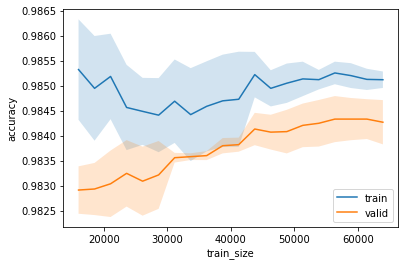

In [141]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего соревнования
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей

На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в соревновании Kaggle Inclass.